# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

# # pycld2
# try:
#   import pycld2 as cld2
# except:
#   !pip install pycld2
#   import pycld2 as cld2

# # deep_translator
# try:
#   from deep_translator import GoogleTranslator
# except:
#   !pip install deep-translator
#   from deep_translator import GoogleTranslator

# Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/TextMiningProject'

Mounted at /content/drive
/content/drive/MyDrive/TextMiningProject


In [3]:
train = pd.read_excel('Data/train.xlsx', index_col='index')
train_reviews = pd.read_excel('Data/train_reviews.xlsx', index_col='index')

# 1. Exploratory Data Analysis

## 1.1 train.xlsx

In [4]:
# define dataframe variable
dataframe = train.copy()
dataframe = dataframe.reset_index()

# define target feature
target_feature = 'unlisted'

In [5]:
# display head & tail
dataframe

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0
...,...,...,...,...
12491,12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1


In [6]:
# data types
print('Data Types:', '\n')
dataframe.dtypes

Data Types: 



index           int64
description    object
host_about     object
unlisted        int64
dtype: object

In [7]:
# missing values
print('Missing Values:', '\n')
pd.concat([dataframe.isnull().sum(), dataframe.eq('').sum()], keys=['Nulls','Empty Strings'], axis=1)

Missing Values: 



,Nulls,Empty Strings
index,0,0
description,0,0
host_about,0,0
unlisted,0,0


In [8]:
# duplicated rows
print('Duplicated Rows:', '\n')
dataframe.duplicated().sum()

Duplicated Rows: 



0

In [9]:
# descriptive statistics
print('Descriptive Statistics:', '\n')
dataframe.describe(include='all').T

Descriptive Statistics: 



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,12496.0,NaN,NaN,NaN,6248.5,3607.428817,1.0,3124.75,6248.5,9372.25,12496.0
description,12496,11788,<b>License number</b><br />Exempt,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_about,12496,4396,We are Feels Like Home Holiday Rentals.\nA com...,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unlisted,12496.0,NaN,NaN,NaN,0.277129,0.447598,0.0,0.0,0.0,1.0,1.0


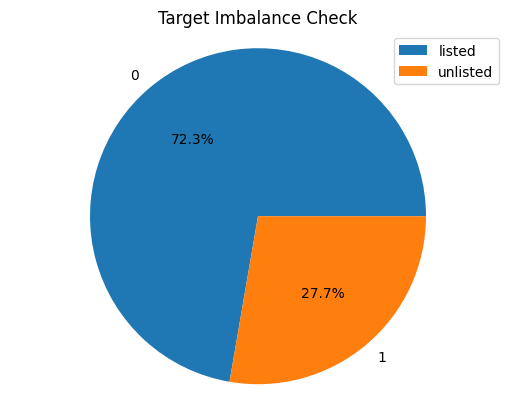

In [10]:
# check for imbalance
# Count the number of instances for each target value
target_counts = dataframe[target_feature].value_counts()

# Create a pie chart
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Target Imbalance Check')
plt.legend(labels=['listed', 'unlisted'])
plt.show()

## 1.2 train_reviews.xlsx

In [11]:
# define dataframe variable
dataframe = train_reviews.copy()
dataframe = dataframe.reset_index()

In [12]:
# display head & tail
dataframe

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."
...,...,...
721397,12494,"We had a good time, the apartment has a great ..."
721398,12494,Great apartment in very central location. The ...
721399,12494,"We are Airbnb Super Hosts too, so trust me, Li..."
721400,12494,We had a lovely stay at this apartment. Sofia ...


In [13]:
# data types
print('Data Types:', '\n')
dataframe.dtypes

Data Types: 



index        int64
comments    object
dtype: object

In [14]:
# missing values
print('Missing Values:', '\n')
pd.concat([dataframe.isnull().sum(), dataframe.eq('').sum()], keys=['Nulls','Empty Strings'], axis=1)

Missing Values: 



,Nulls,Empty Strings
index,0,0
comments,0,0


In [15]:
# duplicated rows
print('Duplicated Rows:', '\n')
dataframe.duplicated().sum()

Duplicated Rows: 



305

In [16]:
# descriptive statistics
print('Descriptive Statistics:', '\n')
dataframe.describe(include='all').T

Descriptive Statistics: 



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,721402.0,NaN,NaN,NaN,6212.577535,3604.810218,1.0,3058.0,6242.0,9265.0,12494.0
comments,721402,705644,.,908,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Preprocessing (train.xlsx)

In [33]:
def lowercase(df):
  '''
  lowercases all the text in the dataframe
  '''
  for col in df.columns:
      df[col] = df[col].apply(lambda x: x.lower() if type(x) == str else x)
  return df

def general_regex(df):
  '''
  general regex cleaning steps
  '''
  # read in regex_patterns.json
  # regex_patterns = pd.read_json('regex_patterns_lukas.json').transpose().rename(columns={0:'new_value'})
  for col in df.columns:
      # remove html tags
      remove_html = re.compile('<.*?>')
      df[col] = df[col].apply(lambda x: re.sub(remove_html,' ',x) if type(x) == str else x)
      # remove double space
      remove_dspace = re.compile(' +')
      df[col] = df[col].apply(lambda x: re.sub(remove_dspace,' ',x) if type(x) == str else x)
      # remove punctuation
      remove_punctuation = re.compile('[^\w\s]')
      df[col] = df[col].apply(lambda x: re.sub(remove_punctuation,'',x) if type(x) == str else x)
      # remove observed patterns listed "regex_patterns.json"
      # for pattern in regex_patterns.index:
      #     df[col] = df[col].apply(lambda x: re.sub(f'{pattern}',f'{regex_patterns.loc[pattern]["new_value"]}',x) if type(x) == str else x)
  return df

def detect_language(dataframe, column):
  '''
  detect language
  '''
  return dataframe[column].apply(lambda x: cld2.detect(x)[-1][0][0])

############################################################################################################################################

def text_preprocessing(dataframe):
  # lowercase non-numeric features 
  categorical_features = list(dataframe.select_dtypes(exclude = np.number).columns)
  for col in categorical_features:
      dataframe[col] = dataframe[col].apply(lambda x: x.lower() if type(x) == str else '')
    
  # drop duplicates
  dataframe = dataframe.reset_index()
  dataframe = dataframe.drop_duplicates()

  # 
  for col in categorical_features:
    col_clean = col + '_clean'
    # remove html tags
    remove_html = re.compile('<.*?>')
    dataframe[col_clean] = dataframe[col].apply(lambda x: re.sub(remove_html,' ',x))
    # remove double space
    remove_dspace = re.compile(' +')
    dataframe[col_clean] = dataframe[col_clean].apply(lambda x: re.sub(remove_dspace,' ',x))
    # remove punctuation
    remove_punctuation = re.compile('[^\w\s]')
    dataframe[col_clean] = dataframe[col_clean].apply(lambda x: re.sub(remove_punctuation,'',x))

  return dataframe

In [34]:
train_preprocessed = text_preprocessing(train)

In [35]:
train_reviews_preprocessed = text_preprocessing(train_reviews)

# 5. Encoding